In [31]:
# imports and loadings
import os
import sys
sys.path.insert(0, '../functions/')
import mRNA_ratios as mr
import create_data_for_single_gene as cdg

import pandas as pd
import ast
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# settings
genes = ['b2818']#, 'b3959', 'b3958', 'b3359', 'b3957', 'b0273', 'b3172', 'b3960', 'b4254'] #'b1101', 'b1817', 'b1818', 'b1819', 


# below are the default flags used if nothing is pre-set
# set flags by editing the "saved_flags.csv" in the ../data folder
flags_df = pd.read_csv('../data/saved_flags-Copy1.csv', index_col = 0)
t_half_life_deg = 300
stable_flags = { # these do not change gene by gene
    # overall
    'only_create_ratios' : True,
    'only_check_KdRNAPCrp' : True, # if True, quit out of code after generating KdRNAPCrp, done to see if it is generating valid values through sanity check plots
    'save_results' : True, # saves resulting figures and cAct/cInh values of the previous run to the save_results_run folder
    'include_Amy_samples' : True, # append on Amy's stationary phase samples to analysis
    'remove_outliers' : True, # removes samples that do not correlate well with others, see ../data_cleaning/1_locate_outliers_to_drop.ipynb
    'case' : 'argR', # only used for remove_outliers right now
    
    # KdRNAPCrp optimization
    'KdRNAPCrp_sanity' : True, # if True, return sanity plots from this optimization
    # GAMs
    'supress_output' : False,
    'use_greedy' : True, # use the greedy algo values (if False, uses the results of the GA)
    'run_on_all' : False, # run on all genes that are in the saved output folder
    'limit_samples' : ['b2818', 'b3959', 'b3958', 'b3359', 'b3957', 'b0273', 'b3172', 'b3960', 'b4254'], #['b1101', 'b1817', 'b1818', 'b1819'], # if run_on_all is False, limit to these samples (or which of them are available)
    'delete_old' : True,
    'run_seperate' : False, # run cActivator and cInhibitor solvers seperately
    
    # input constants for GAMs (all get logged inside GAMs so pass in un-logged)
    'act_TF_conc_lo' : 1e-10,
    'act_TF_conc_up' : 1e-5,
    'act_Kd_lo' : 1e-10,
    'act_Kd_up' : 1e-6,
    'inh_TF_conc_lo' : 1e-10,
    'inh_TF_conc_up' : 1e-5,
    'inh_Kd_lo' : 1e-10,
    'inh_Kd_up' : 1e-6,
    # objective function weightings
    'weight_act_obj1' : 1,
    'weight_inh_obj1' : 1,
    'weight_act_obj2' : 0,
    'weight_inh_obj2' : 0,
    'weight_mRNA_match' : .1,
    'weight_act_corr' : 0.00000000000000001,
    'weight_inh_corr' : 0.00000000000000001,
    
    
    # misc
    'eq_str' : 'Eq(mRNARatio,((cActivator*KdRNAP + KdRNAPCrp)*(KdRNAP + RNAP + \
            KeqOpening*RNAP))/((1 + cActivator + cInhibitor)*KdRNAP*KdRNAPCrp + \
            cActivator*KdRNAP*(1 + KeqOpening)*RNAP + KdRNAPCrp*(1 + \
            KeqOpening)*RNAP))',
    
    # cell_constants'
    'cell_constants_RNAP': 10**-6,
    'cell_constants_mRNA_total': 1800, # Total mRNA/cell from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3554401
    'cell_constants_cell_volume': 10**-15, # Liters from https://bionumbers.hms.harvard.edu/bionumber.aspx?id=100004&ver=19
    'cell_constants_kDeg': np.log(2)/t_half_life_deg, # Rate of degradation
    'cell_constants_promoterConcVal': 10**-9, # Promoter concentration
    'cell_constants_u': 1/3600, # Growth rate
}


def show_figure(fig):

    # create a dummy figure and use its
    # manager to display "fig"

    dummy = plt.figure()
    new_manager = dummy.canvas.manager
    new_manager.canvas.figure = fig
    fig.set_canvas(new_manager.canvas)


In [32]:
# multiprocess run
gene = 'b2818'

# overall setup
folders = [val for val in os.listdir('../data/saved_run_results') if 'run' in val]
if len(folders) == 0:
    run_ct = 1
else:
    run_ct = max([int(val.split('_')[1]) for val in folders]) + 1
new_run_folder = '../data/saved_run_results/run_'+str(run_ct)
os.mkdir(new_run_folder)

# put the flags df in there
flags_df.to_csv(new_run_folder+'/saved_flags.csv')

# setup inputs
temp_flags = dict(flags_df.loc[gene])

# need to convert some flags from strings to lists
for col in ['basal_conditions', 'target_range', 'cActivator', 'cInhibitor']:
    temp_flags[col] = ast.literal_eval(temp_flags[col])

# convert cell constants into a dictionary
temp_flags.update({'cell_constants' : {
    'RNAP' : stable_flags['cell_constants_RNAP'],
    'mRNA_total' : stable_flags['cell_constants_mRNA_total'],
    'cell_volume' : stable_flags['cell_constants_cell_volume'],
    'kDeg' : stable_flags['cell_constants_kDeg'],
    'promoterConcVal' : stable_flags['cell_constants_promoterConcVal'],
    'u' : stable_flags['cell_constants_u'],
    'mRNA_total' : stable_flags['cell_constants_mRNA_total'],
}})
temp_flags.update({'eq_str' : stable_flags['eq_str']})
temp_flags.update({'save_results' : stable_flags['save_results']})
temp_flags.update({'save_results_folder' : new_run_folder})
temp_flags.update({'include_Amy_samples' : stable_flags['include_Amy_samples']})
temp_flags.update({'only_check_KdRNAPCrp' : stable_flags['only_check_KdRNAPCrp']})
temp_flags.update({'only_create_ratios' : stable_flags['only_create_ratios']})
temp_flags.update({'KdRNAPCrp_sanity' : stable_flags['KdRNAPCrp_sanity']})
temp_flags.update({'remove_outliers' : stable_flags['remove_outliers']})
temp_flags.update({'case' : stable_flags['case']})
temp_flags.update({'central_gene' : gene})

ret_figs = cdg.create_data_for_gene(temp_flags)
ratios_df = pd.read_pickle(new_run_folder+'/'+gene+'/ratios_df.pkl')

hi


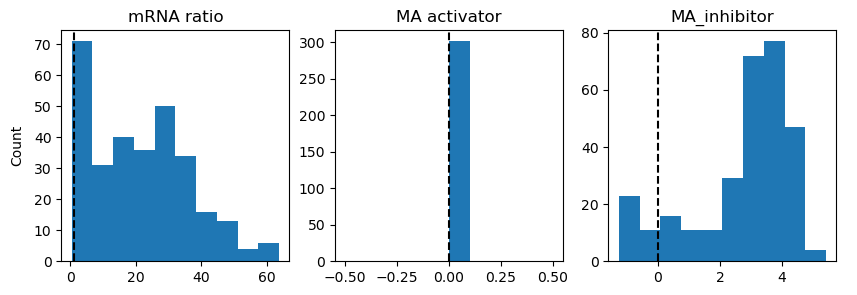

In [26]:
show_figure(ret_figs[0])

In [27]:
ratios_df = pd.read_pickle(new_run_folder+'/'+gene+'/ratios_df.pkl')

In [28]:
pd.set_option('display.max_rows', 500)
ratios_df.sort_values(by = 'actual_mRNA_ratio')

,MA_activator,MA_inhibitor,actual_mRNA_ratio
starve_series__t07_starve__1,0,-0.550796,0.449562
starve_series__t09_starve__1,0,-0.951117,0.478312
starve_series__t17_starve__1,0,-1.176910,0.479237
starve_series__t05_starve__1,0,-0.626495,0.497506
starve_series__t14_starve__2,0,-1.209782,0.500708
starve_series__t07_starve__2,0,-0.607493,0.512696
starve_series__t14_starve__1,0,-1.262838,0.525959
starve_series__t10_starve__1,0,-0.900939,0.528492
starve_series__t06_starve__1,0,-0.516678,0.534747
starve_series__t12_starve__2,0,-1.190486,0.538738


In [17]:
ls ../data/saved_run_results/run_200/b2818

figures.pkl  ratios_df.pkl
